In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from IPython.core.display import HTML
from scipy.stats import norm, poisson,expon,lognorm,skewnorm,exponnorm,skew,kstest
from math import pi
%matplotlib inline

In [2]:
# Import the cleaned loan data produced by Data cleaning notebook.
loan_data = pd.read_csv('../data/loan_data_eda.csv', index_col=False)

In [3]:
def column_search(df, name, return_style='loc', threshold='contains'):
    """ Partial/full matching of column names returning either Pandas .loc or .iloc compatible indices """
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None

# Capital loss prevention : data exploration

### 1. The types of data present in the dataset.

The goal of this project is to create a predictive model for the outcome of loans and for how much capital can be recovered from a charged off loan. In the modeling process there are a large number of hyperparameters and choices to be made in modifying the models. To get a sense for how to choose these parameter values and choices should be made we should inform ourselves via the data itself.

An additional aspect of this problem to take into consideration are the laws such as the Equal Credit Opportunity Act (ECOA) which prevents discrimination of offering loans based on many criteria. This is an important component in the ethics of providing financial loans. 

In [4]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 145 entries, loan_amnt to settlement_date
dtypes: float64(112), object(33)
memory usage: 2.4+ GB


Approximately a fourth of the data is of the "object" data type which in this case can be alternatively referred to as categorical.

In [5]:
loan_data.select_dtypes(include='object').columns

Index(['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan',
       'purpose', 'zip_code', 'addr_state', 'earliest_cr_line',
       'initial_list_status', 'last_pymnt_d', 'next_pymnt_d',
       'last_credit_pull_d', 'application_type', 'verification_status_joint',
       'sec_app_earliest_cr_line', 'hardship_flag', 'hardship_type',
       'hardship_reason', 'hardship_status', 'hardship_start_date',
       'hardship_end_date', 'payment_plan_start_date', 'hardship_loan_status',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date'],
      dtype='object')

**Main takeways from this preview**

    1. The data contains both information on the loan itself and the borrower/customer.
    2. There is a non trivial number of time dependent data features.

In working with customer data we need to be really careful to not perform any illegal or unethical actions; luckily
the information is not identifying in this case. 
For the time dependence care must be
taken such that we do not accidentally contaminate the modeling process with data from the "future". This
is commonly referred to as "data snooping". 

In the data cleaning process the missing values of the categorical variables were replaced with a new "Missing" category. In the numerical case the course of action is not so clear. From above we know that there are 105 numerical features; let's see how many do *not* have missing values.

In [6]:
len(loan_data.select_dtypes(exclude='object').dropna(axis='columns').columns)

21

The vast majority of numerical features are missing values; this creates a problem for the modeling process. This is mainly because there is no surefire method for handling these values, and sometimes models cannot handle missing values. One choice is imputation, but this is not well motivated and should not really be used without a very compelling argument, as it introduces a large amount of bias into the problem. This can be easily demonstrated by the change in the summary statistics of the data.
    What can be done then? In order to maintain the integrity of the data set, the features missing values will be dropped to avoid any problems that arise from missing values.

Before we get to the modeling of the data, we should explore the data to help us interpret it. 
Let's motivate why prediction models for this type of data are important along with investigate
one of the time dependent variables. Specifically, let's view the time series of issued loan dates, aggregated by month.

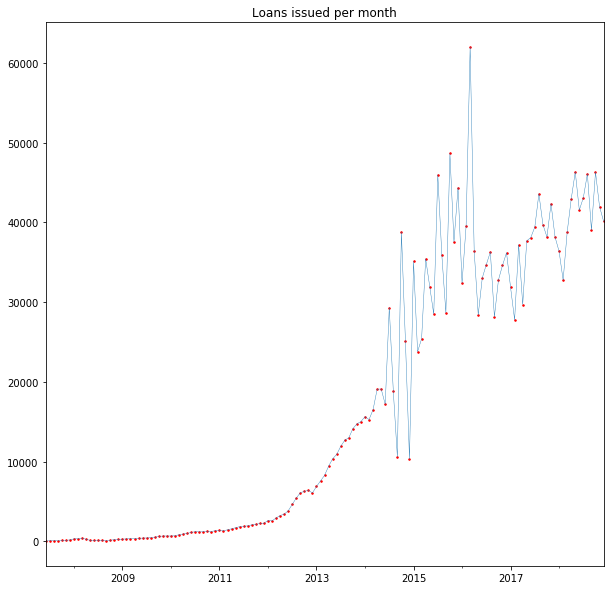

In [7]:
issued = loan_data.issue_d.value_counts()
issued.index = pd.to_datetime(loan_data.issue_d.value_counts().index)
issued.sort_index(inplace=True)
issued.plot(marker='.', color='red',linestyle='none',markersize=3,figsize=(10,10))
issued.plot(linewidth=0.4)
plt.title('Loans issued per month')
plt.show()

The erratic nature of the monthly loans issued obscures the growth trend; aggregate by year to get a better
depiction of average growth.

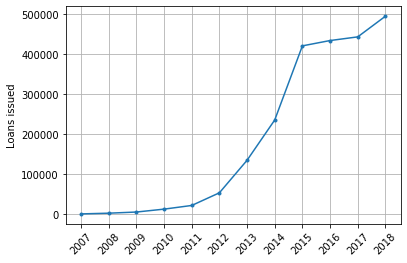

In [8]:
# Answer to the question: How does the number of issued loans per annum grow over time? Answer: Parabolically.

# Sum over each year to get loans issued per year.
yeargroups = issued.groupby(by=issued.index.strftime('%Y')).sum()
# There happen to be 12 years in the values, use these as the domain of
# values to fit on. 
x = np.arange(12)
plt.plot(yeargroups.index, yeargroups.values, marker='.')
plt.xticks(rotation=45)
plt.ylabel('Loans issued')
plt.savefig('annual_issued_loans.jpg', bbox_inches='tight')
plt.grid()
_ = plt.show()

As previously mentioned, the amount of money lost (or at least needed to be recovered) by charged-off loans is in the billions. Using the Lending Club loan dataset the main goals are to create a predictive model for whether a loan will be charged off or not as well as a model for the amount of money that can be recovered from charged off loans. Before we begin on the production of the main deliverables it’s good to get a good feel for the dataset. In this dataset there are categorical variables in the form of strings, discrete numerical variables, and continuous numerical variables. The data can also be segmented into information describing the borrower (geographical location, income, etc.) and information about the loan (principal amount, interest rate, etc.). There are also features that are time dependent and can be naturally visualized as a time series. One example of a time dependent feature is the date when each loan was issued. Aggregating by year and performing a polynomial fit assuming parabolic growth for the number of loans issued per year results in a respectable r-squared value (coefficient of determination) value of 0.92. This nonlinear growth implies that our main deliverable, the model which predict the outcome of a loan should become more important over time. 

A parabolic fit seems to capture the recent average growth trend but with the cavaet that this growth is unsustainable. This is only a figure to give a sense of how the loans have grown ***up to the present moment***. Aggregating by the (top three) statuses of the loan shows the time distribution of when fully paid, current and charged off loans. All of the loans have terms of three or five years so it's understandable that the approximate maximum of the fully paid loans and charged off loans occurs in the same range, three to five years ago. (The most current date in the data set is December 1st 2018).

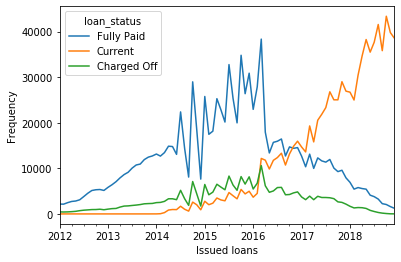

In [9]:
time_series_loan_status = loan_data.groupby('loan_status').issue_d.value_counts()
time_series_loan_status = time_series_loan_status.unstack().swapaxes('index','columns')
time_series_loan_status.index = pd.to_datetime(time_series_loan_status.index)
time_series_loan_status = time_series_loan_status.fillna(value=0)
top_3_statuses = time_series_loan_status.loc[:, time_series_loan_status.sum().sort_values(ascending=False).index[:3]].astype(int)
top_3_statuses_from_2012_on = top_3_statuses.sort_index()['2012':]
_ = top_3_statuses_from_2012_on.plot()
_ = plt.xlabel('Issued loans')
_ = plt.ylabel('Frequency')

### 2. Hidden population subsets

One such variable is the percentage of available credit being utilized by the borrower. Plotting this variable shows some borrowers are above the theoretical threshold of 100%. This is a good example of why generalization is so important as values which are **outside of what would be expected** occur frequently in real data. 

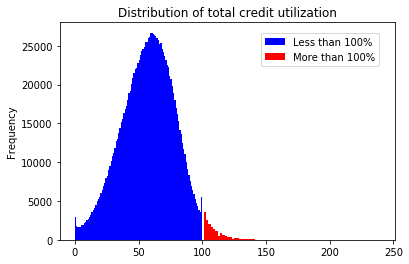

In [10]:
# Separate into above the 100% threshold and below
more_than_max_credit = loan_data[loan_data.all_util > 100]
less_than_max_credit = loan_data[loan_data.all_util <= 100]

leftax = less_than_max_credit.all_util.plot.hist(bins=100, color='b')
more_than_max_credit.all_util.plot.hist(bins=75,color='r')
plt.legend(('Less than 100%', 'More than 100%'), loc=(0.6,0.8))
plt.title('Distribution of total credit utilization')
_ = plt.show() 

Firstly, the large spike is due to imputation of values at the mean. 

Looking at this distribution, the red region indicates that  number of loan borrowers are above their credit limit; the reason for this is unknown but I'll hypothesize that this among with other properties can help stratify the borrowers into fundamentally different classes.  Look at the loan amounts and average current balances to see the general loan information of each type of borrower

In [11]:
print('The average balance for borrowers utilizing more than 100% of their credit: ${:0.2f}'.format(
      more_than_max_credit.tot_cur_bal.mean()))
print('The average balance for borrowers utilizing less than 100% of their credit: ${:0.2f}'.format(
    less_than_max_credit.tot_cur_bal.mean()))

The average balance for borrowers utilizing more than 100% of their credit: $182575.92
The average balance for borrowers utilizing less than 100% of their credit: $143809.02


In [12]:
print('The average loan amount for borrowers utilizing more than 100% of their credit: ${:0.2f}'.format(
      more_than_max_credit.loan_amnt.mean()))
print('The average loan amount for borrowers utilizing less than 100% of their credit: ${:0.2f}'.format(
    less_than_max_credit.loan_amnt.mean()))

The average loan amount for borrowers utilizing more than 100% of their credit: $11729.86
The average loan amount for borrowers utilizing less than 100% of their credit: $15274.88


The average current balance is actually greater for people utilizing less of their credit, This is not indicative of not paying off loans; it just indicates that people that use less credit on average get larger loans. To get a sense as to whether the separation by credit utilization serves as a significant borrower classifier, we can look at the differences in summary statistics between the two populations. The top ten largest differences of averages of all features are shown. 

In [13]:
statdiff = less_than_max_credit.describe()-more_than_max_credit.describe()
statdiff = statdiff.apply(np.abs).sort_values(by='mean',axis=1, ascending=False).apply(np.round,args=(2,))
statdiff.loc['mean',:].sort_values(ascending=False)[:10].to_frame()

,mean
total_bal_il,79554.51
total_bal_ex_mort,74091.79
total_il_high_credit_limit,53230.34
tot_cur_bal,38766.89
total_rev_hi_lim,19893.15
total_bc_limit,13465.70
annual_inc,10259.81
bc_open_to_buy,9795.65
revol_bal_joint,7974.36
revol_bal,5319.43


The quantity that stands out to me is the total balance excluding mortgage. The averages for each sample population were computed to be approximately 40000 dollars; but it seems that this value nearly doubles when excluding mortgage balances. The hypothesis that results from this is that perhaps there is a difference in home ownership status between the two groups.  

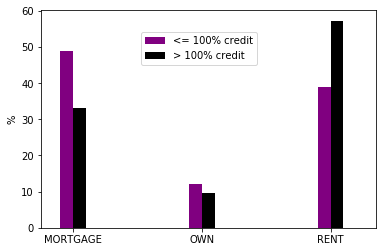

In [14]:
# Plot the percentages of home ownership status of data above and below credit limit. 
moreind = more_than_max_credit.index
lessind = less_than_max_credit.index
home_more = loan_data.loc[moreind,'home_ownership'].value_counts().sort_index()#.values
home_less = loan_data.loc[lessind,'home_ownership'].value_counts().sort_index()#.values
home_less = 100 * home_less.loc[['MORTGAGE','OWN','RENT']] / home_less.sum()
home_more = 100 * home_more.loc[['MORTGAGE','OWN','RENT']] / home_more.sum()

fig = plt.figure() 
ax = fig.add_subplot(111) 

width = 0.4
home_less.plot.bar(ax=ax, rot=0,color=['purple','purple','purple'],position=1,width=0.1)
home_more.plot.bar(ax=ax,rot=0,color=['black','black','black'],position=0,width=0.1)
ax.set_ylabel('%')
ax.legend(('<= 100% credit', '> 100% credit'), loc=(0.3, 0.75))
_ = plt.show()

While the bar plot above does not prove anything it does seem to imply that there is a difference in housing status between the two groups. It seems that a majority of the borrowers over their credit limits are renters while the other borrowers are more likely to either own or mortgage a home. Can home ownership status be used as a distinguishing factor in any other manner? To explore this line of thinking, let's look at the total current balances of all borrowers.
Another quantity that I would have guessed would have a normal distribution is the total current balance of all accounts.
Plotting the histogram, however, is another story.

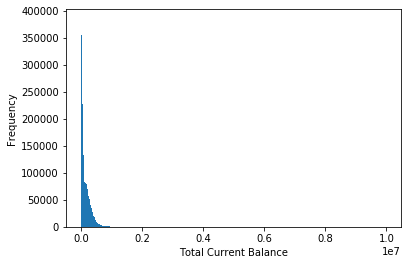

In [15]:
loan_data.tot_cur_bal.plot.hist(bins=500)
plt.xlabel('Total Current Balance')
_ = plt.show()

To reduce the effect of outliers on the distribution plot, I take the logarithm, after removing total current balances equal to zero. By removing the data we must reformulate any hypotheses to only pertain to borrowers with outstanding balances. Again this requires dropping the zeros (which are numerous) such that the transformed data does not contain "-inf" values.

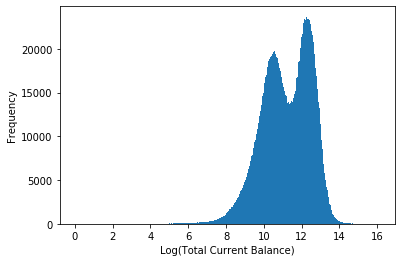

In [16]:
loan_data[loan_data.tot_cur_bal>0].tot_cur_bal.apply(np.log).plot.hist(bins=500)
plt.xlabel('Log(Total Current Balance)')
_ = plt.show()

The result of the logarithmic transformation is a bimodal distribution; to get a vague sense of why there are two local maxima, let's split the data in half by the median value and take the difference of the summary statistics of all features.

In [17]:
more_tot_cur_bal = loan_data[loan_data.tot_cur_bal > loan_data.tot_cur_bal.median()]
less_tot_cur_bal = loan_data[(loan_data.tot_cur_bal < loan_data.tot_cur_bal.median())&(loan_data.tot_cur_bal > 0)]

In [18]:
describe_diff = less_tot_cur_bal.describe()-more_tot_cur_bal.describe() 
abs_describe_diff = describe_diff.apply(np.abs).sort_values(by='mean',axis=1, ascending=False).apply(np.round,args=(2,))
abs_describe_diff.loc['mean',:].sort_values(ascending=False)[:10].to_frame()

,mean
tot_hi_cred_lim,244774.67
tot_cur_bal,220477.28
total_bal_ex_mort,40758.88
annual_inc_joint,34526.89
total_il_high_credit_limit,33351.12
total_bal_il,32165.83
annual_inc,32034.40
avg_cur_bal,19765.32
total_rev_hi_lim,17190.01
revol_bal_joint,14166.07


The large difference in mean in total current balance is a result of how we split the data; the other members of the top three are the total credit limit on all accounts and the total balance excluding mortgages. Looking at the total high credit limit is uninformative because it shares the same distribution as the total current balance.

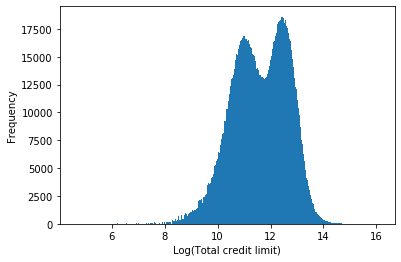

In [19]:
loan_data[loan_data.tot_hi_cred_lim>0].tot_hi_cred_lim.apply(np.log).plot.hist(bins=500)
plt.xlabel('Log(Total credit limit)')
_ = plt.show()

The total balance excluding mortgages, however, looks different. The previous exploration hinted at home ownership being an important separating factor; let us continue the pursuit of the effect of home ownership.

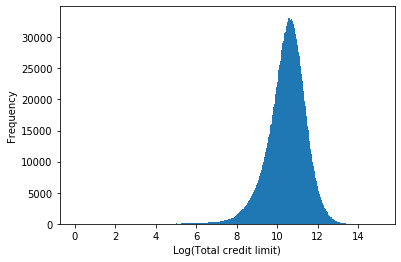

In [20]:
loan_data[loan_data.total_bal_ex_mort>0].total_bal_ex_mort.apply(np.log).plot.hist(bins=500)
plt.xlabel('Log(Total credit limit)')
_ = plt.show()

Let's look first at the approximate behavior of each of mode of the total current balance distribution by splitting the data in half via the median.

In [21]:
# Placeholder variables to save text space
moreind = more_tot_cur_bal.index
lessind = less_tot_cur_bal.index

# Value counts of home ownership status of each sample population
more_tot_cur_bal_home_ownership = loan_data.loc[moreind,'home_ownership'].value_counts().sort_index()
less_tot_cur_bal_home_ownership = loan_data.loc[lessind,'home_ownership'].value_counts().sort_index()

# Take only these three categories as 'NONE' or 'ANY' represent a tiny fraction of borrowers.
less_tot_cur_bal_home_ownership = less_tot_cur_bal_home_ownership.loc[['MORTGAGE','OWN','RENT']] 
more_tot_cur_bal_home_ownership = more_tot_cur_bal_home_ownership.loc[['MORTGAGE','OWN','RENT']]

# Convert to percentanges
less_tot_cur_bal_home_ownership = 100 * less_tot_cur_bal_home_ownership / less_tot_cur_bal_home_ownership.sum()
more_tot_cur_bal_home_ownership = 100 * more_tot_cur_bal_home_ownership / more_tot_cur_bal_home_ownership.sum()

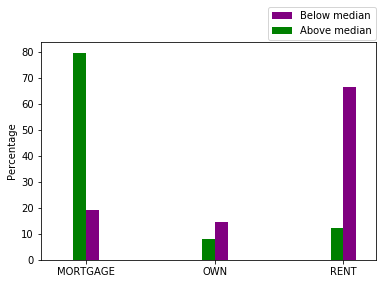

In [22]:
fig = plt.figure() 
ax = fig.add_subplot(111) 
# Bar plot of home ownership status counts. 
less_tot_cur_bal_home_ownership.plot.bar(ax=ax, rot=0,color=['purple','purple','purple'],position=0,width=0.1)
more_tot_cur_bal_home_ownership.plot.bar(ax=ax,rot=0,color=['green','green','green'],position=1,width=0.1)
ax.legend(('Below median','Above median'),loc=(0.68,1.01))
ax.set_ylabel('Percentage')
plt.show()

Much more drastically than was the case with credit utilization is the difference in home ownership status between each mode of the distribution. Let's visualize this by plotting the total current balance (log) distribution with respect to each category. 
Let's plot the total current balance distribution by home ownership status

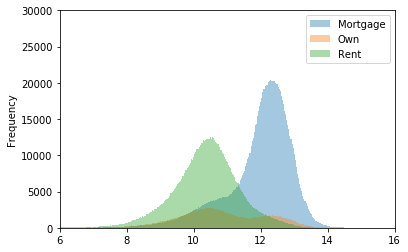

In [23]:
# Work around to use groupby
topthree_homeownership = loan_data.loc[loan_data.home_ownership.isin(['RENT','OWN','MORTGAGE']), :]
topthree_homeownership = topthree_homeownership[topthree_homeownership.tot_cur_bal > 0]
topthree_homeownership.loc[:,'log_tot_cur_bal'] = topthree_homeownership.tot_cur_bal.apply(np.log)

# Histograms of total current balance for the three separate home ownership types.
topthree_homeownership.groupby(by='home_ownership').log_tot_cur_bal.plot.hist(bins=500,alpha=0.4)
plt.legend(('Mortgage','Own','Rent'))
plt.xlim([6,16])
plt.ylim([0,30000])
_ = plt.show()

Own and mortgage still look like they're bimodal/ but the total current balance distribution for renters seems to be
unimodal. This almost seems like it's hinting at the possibility that there are "hidden categories"
of customers reference in the section title. The idea I have in my head at least is that perhaps there is a useful way of subdividing or partitioning
the data such that these subsets could each be treated as their own population; that is to say, each would have a separate model instead of there being single models for loan outcome prediction and recovered capital regression. The problem is that
the next step forward, breaking down the mortgage and own categories doesn't seem to be as obvious after repeating the summary statistics differences.
Continuing with the data exploration, a unique and interesting quantity is the distribution of loan amounts; it really shows the affect of human psychology by how the distribution manifests.

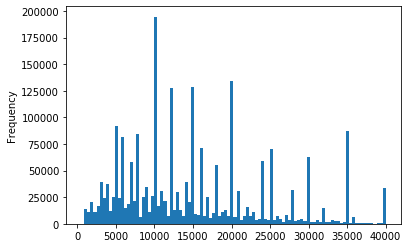

In [24]:
loan_data.loan_amnt.plot.hist(bins=100)
plt.show()

Why is this distribution so strange? As can be seen, the distribution seems to be clustered around "pretty" numbers. This includes round numbers like
multiples of five thousand and ten thousand. To show this explicitly, let's look at the top ten most frequent loan values.
This makes the loan amount distribution some strange quasi-discrete distribution.

In [25]:
loan_data.loan_amnt.value_counts().sort_values(ascending=False).head(10)

10000.0    187236
20000.0    131006
15000.0    123226
12000.0    121681
35000.0     86285
5000.0      84765
8000.0      75033
6000.0      72089
25000.0     66453
16000.0     66418
Name: loan_amnt, dtype: int64

Figuring out how variables are distributed is important (and the focus of the statistical analysis portion of this project). The reason for this importance is because an incorrect assumption regarding the distribution could drastically affect claims
and the interpretation of data.

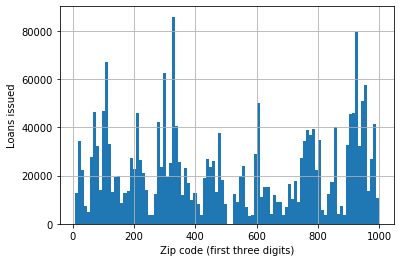

In [26]:
geog = loan_data[loan_data.zip_code!='Missing'].zip_code.str.split('xx').str.join(sep='').astype(float)
geog.hist(bins=100)
plt.xlabel('Zip code (first three digits)')
plt.ylabel('Loans issued')
_ = plt.show()

Looking up the top five zip codes correspond to: 
Brooklyn, NY. Oakland, CA. Dallas, TX. Chicago, IL. Atlanta, GA.
This distribution is likely just correlated with population and so is not very informative.
The goal of stratifying the earliest credit line by the purpose of the loan was to see if different age demographics use loans for different purposes. This would be measured by differences in the mean between these stratified distributions, as I believe it is a fair assumption that everyone gets their first credit line (earliest) around the same age.

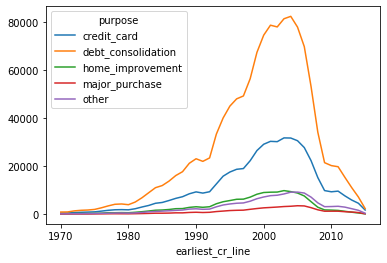

In [27]:
dt_loan_data = loan_data[['purpose','earliest_cr_line']]
dt_loan_data = dt_loan_data[dt_loan_data.earliest_cr_line!='Missing']
dt_loan_data = dt_loan_data.set_index('earliest_cr_line')
dt_loan_data.index = pd.to_datetime(dt_loan_data.index)

top_five_purposes = dt_loan_data.groupby([dt_loan_data.index.year,'purpose']).size().unstack().sum().sort_values(ascending=False)[:5].index.tolist()
top_five_purposes_df = dt_loan_data[dt_loan_data.purpose.isin(top_five_purposes)]
_ = top_five_purposes_df.groupby([top_five_purposes_df.index.year,'purpose']).size().unstack().loc[1970:].plot()

There doesn't seem to be any distinctive behavior between loan purposes, this would have been evidenced by difference in the mean of each the time series. 

I wanted to investigate what the relationship between subgrades and grades are; turns out to be pretty boring since
subgrades are approximately distributed uniformly
across grades (each of the five subgrades is approximately 20% of the grade's values).

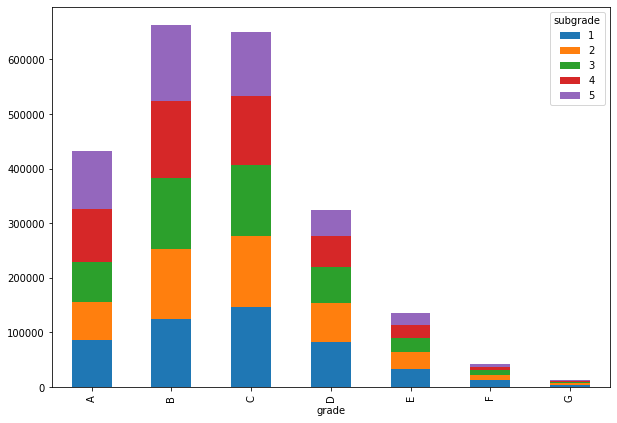

In [28]:
# Subgrades are of format Letter-number (e.g. C1). 
letters, subnumber = loan_data['sub_grade'].str.slice(0,1), loan_data['sub_grade'].str.slice(1).astype(int)
gradesubgrade_df = pd.concat([letters,subnumber],axis=1)
gradesubgrade_df.columns=['grade','subgrade']

# Plot of loan grades and subgrades; it appears that subgrades uniformly stratify each grade
gradesubgrade_df.groupby(['grade','subgrade']).size().unstack().plot.bar(stacked=True,figsize=(10,7))
plt.show()

### 3. Investigation of the target variables
The main quantity we want to predict is the outcome of loan status. Let's get an idea as to the values this quantity can take.

To be transparent, here are the full status categories.

In [29]:
loan_status_categories = loan_data.loan_status.unique().tolist()
loan_status_categories

['Does not meet the credit policy. Status:Fully Paid',
 'Does not meet the credit policy. Status:Charged Off',
 'Fully Paid',
 'Charged Off',
 'Current',
 'Late (31-120 days)',
 'In Grace Period',
 'Late (16-30 days)',
 'Default']

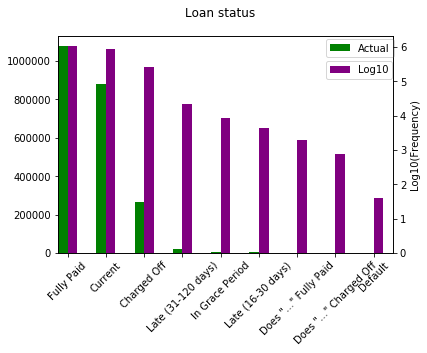

In [30]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
loan_statuses = loan_data.loc[:,'loan_status'].value_counts()
loan_statuses_tmp = loan_statuses.reset_index()
loan_statuses_tmp.loc[loan_statuses_tmp['index'].apply(len)>20, 'index'] = loan_statuses_tmp.loc[loan_statuses_tmp['index'].apply(len)>20, 'index'].apply(lambda x : x[:5]+'"..." '+x[40:])
loan_statuses_tmp = loan_statuses_tmp.set_index(keys=['index'])
loan_statuses_tmp.index.name = ''
loan_statuses_tmp.plot.bar(rot=75,ax=ax1, width=0.25, position=1,color='green')
loan_statuses_tmp.apply(np.log10).plot.bar(rot=75, ax=ax2,width=0.25, position=0,color='purple')
fig.suptitle('Loan status')
ax.set_ylabel('Frequency')
ax2.set_ylabel('Log10(Frequency)')
ax1.legend(('Actual',),loc=(0.8, 0.9))
ax2.legend(('Log10',), loc=(0.8, 0.8))
ticks = ax1.get_xticklabels()
for t in ticks:
    t.set_rotation(45)
plt.savefig('loan_status_categories.jpg',bbox_inches='tight')
plt.show()

As we can see by this figure, the vast majority of loans fall into three
categories: "Fully paid", "Current", and "Charged Off". Because of the time dependence of the problem, the quantity being modeled is modified because of this. The modification is to predict the outcome of loans *that have already matured*. Therefore we can prune the loans which have not concluded. In addition, to make the problem a relatively balanced, binary classification problem the only categories that are retained are "Fully paid" and "Charged Off". The binary distribution plot shows the proportion of loans with bad outcomes.

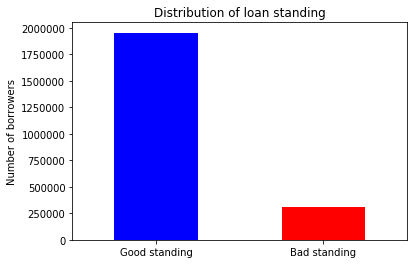

In [31]:
_ = loan_data.loan_status.map({'Fully Paid':0, 'Current':0}).fillna(1).astype(int).value_counts().plot.bar(color=['blue','red'])
loc,lab = plt.xticks()
_ = plt.xticks(loc, labels=['Good standing','Bad standing'], rotation=0)
_ = plt.ylabel('Number of borrowers')
_ = plt.title('Distribution of loan standing')
_ = plt.savefig('good_bad_loan_status.jpg', bbox_inches='tight')

Perhaps one of the most important tasks is to determine which variables are time dependent as forgetting to do so
can easily introduce bias by virtue of data snooping. The following are lists of all of the time dependent features. 

In [32]:
# Time dependent numerical columns
# Any variables involving recovered funds will taint recovery amount predictions. 
# Can technically include one column and then split time series with TimeSeriesSplit. 
time_dependent_numerical_features = ['acc_now_delinq', 'acc_open_past_24mths',
 'chargeoff_within_12_mths','collection_recovery_fee', 'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt',
 'inq_last_12m', 'inq_last_6mths','mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd','num_tl_120dpd_2m','num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
 'open_acc_6m', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m','pct_tl_nvr_dlq','tot_coll_amt',
 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp']

time_dependent_categorical_features = ['last_credit_pull_d', 'last_pymnt_d']

The main concern is the order of these time dependent variables in regards to training and testing data sets for the models as well as for cross validation. If future data is accidentally used in the training then the predictions are essentially worthless. This goes down all the way to the level of normalization; that is, if normalizing the data then one should be sure to only normalize with respect to the training set.

How should these be accounted for in the modeling process? For the loan classification process, all time dependent quantities need to be removed from the model training process for the loan classification problem, as the model is attempting to predict a decision made at a certain point in time. The model for the recovery amounts is agnostic of time as it merely wants to predict the amount that can be recovered *going forward*; it is not a time sensitive decision; therefore, no considerations need to be made for the second stage of the capital recovery model. 

Let's look at the other quantity we are trying to predict, the amount of money recovered from loans. A naive approach of just plotting the distribution leads to an unhelpful plot. 

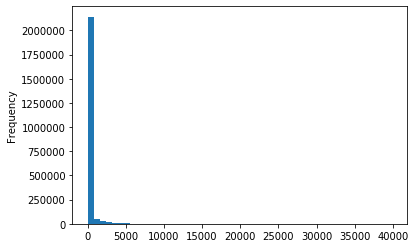

In [33]:
_ = loan_data.recoveries.plot.hist(bins=50)
plt.xlabel('Recoveries from defaulted loans($)')


As can be seen, nearly all of the loans have zero dollars recovered; but this is because we did not take into account the fact that most loans do not *need* to have money recovered from them, as they are not charged off (as indicated by the binary bar plot above). Subsetting by the loans that have been charged off should give us a better idea of the distribution.

There are 268559 defaulted loans
There are 184684 defaulted loans with a non-zero recovery amount


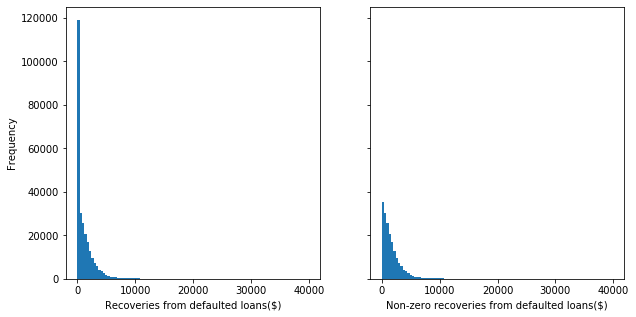

In [40]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5), sharey=True)
chargedoffloans = loan_data[loan_data.loan_status=='Charged Off']
nonzero_chargedoffloans = loan_data[(loan_data.loan_status=='Charged Off')&(loan_data.recoveries>0)]

print('There are {} defaulted loans'.format(len(chargedoffloans)))
print(('There are {} defaulted loans with a non-zero recovery amount'
      ).format(len(nonzero_chargedoffloans)))

_ = chargedoffloans.recoveries.plot.hist(bins=100, ax=ax1)
ax1.set_xlabel('Recoveries from defaulted loans($)')
_ = nonzero_chargedoffloans.recoveries.plot.hist(bins=100, ax=ax2)
ax2.set_xlabel('Non-zero recoveries from defaulted loans($)')
plt.savefig('loan_recovery_distribution.jpg',bbox_inches='tight')


It seems that there are a large number of charged-off loans that have not had much if any capital recovered from them; this serves as additional motivation for the second step of the two-step modeling recommendation system. This distribution can cause issues and so I also explore modeling only the loans whose recoveries are non-zero.

In [36]:
print('The percentage of defaulted loans with recoveries is {}'.format(100*np.round(184684/268559,3)))

The percentage of defaulted loans with recoveries is 68.8


The total amount of money owed by the borrowers of defaulted loans is given by subtracting total payment from principal amount + interest

In [37]:
chargedoffloans = loan_data[loan_data.loan_status=='Charged Off']
remaining_balance = (chargedoffloans.loan_amnt + chargedoffloans.total_rec_int)-chargedoffloans.total_pymnt
print(('The defaulted loans represent for {} billion dollars of lost capital'
      ).format(np.round(remaining_balance.sum()/10**9,4)))

The defaulted loans represent for 2.6757 billion dollars of lost capital
